<a href="https://colab.research.google.com/github/milicasopalovic/RI_rokovi/blob/main/inicijalni__model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://gitlab.com/milicasopalovic/ip2-projekat.git

Cloning into 'ip2-projekat'...
remote: Enumerating objects: 10572, done.
remote: Counting objects: 100% (6884/6884), done.
remote: Compressing objects: 100% (6883/6883), done.
remote: Total 10572 (delta 2), reused 6877 (delta 1), pack-reused 3688 (from 1)
Receiving objects: 100% (10572/10572), 157.36 MiB | 17.07 MiB/s, done.
Resolving deltas: 100% (200/200), done.
Updating files: 100% (14601/14601), done.


In [2]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import load_img, img_to_array, save_img, image_dataset_from_directory
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from collections import Counter
import cv2
import imghdr
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

<ipython-input-2-2871b730e5d6>:11: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trening_dir = './ip2-projekat/skup_podataka_original/trening'
test_dir = './ip2-projekat/skup_podataka_original/test'

batch_size = 32
img_height, img_width = 224, 224

# Kreiranje ImageDataGenerator-a sa normalizacijom
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.2)

# Generator za trening (80% podataka)
train_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Deo za trening
)

# Generator za validaciju (20% podataka)
validation_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Nije potrebno mešanje
    subset='validation'  # Deo za validaciju
)

# Generator za test skup (bez podele)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Test ne mešamo da bismo dobili tačne metrike
)


Found 1029 images belonging to 37 classes.
Found 240 images belonging to 37 classes.
Found 571 images belonging to 37 classes.


In [5]:
from sklearn.utils.class_weight import compute_class_weight


# Imena klasa i njihovi indeksi
imena_klasa = list(train_generator.class_indices.keys())
print("Klase:", imena_klasa)

# Prebrojavanje uzoraka po klasama
broj_uzoraka_po_klasi = train_generator.classes  # Lista klasa za svaku sliku
print("Broj uzoraka po klasama:", np.bincount(broj_uzoraka_po_klasi))

# Izračunavanje težina klasa
tezine_klasa = compute_class_weight(
    class_weight='balanced',  # Balansiranje na osnovu broja uzoraka
    classes=np.unique(broj_uzoraka_po_klasi),
    y=broj_uzoraka_po_klasi
)
tezine_klasa = dict(enumerate(tezine_klasa))  # Konverzija u format koji fit() razume
print("Težine klasa:", tezine_klasa)

Klase: ['aenar', 'andorian', 'antedian', 'arcadian', 'arcturian', 'axanar', 'bajoran', 'benzite', 'bolian', 'borg', 'breen', 'brikar', 'cardassian', 'changeling', 'deltan', 'denobulan', 'dosi', 'ferengi', 'gorn', 'hirogen', 'human', "jem'Hadar", 'kazon', 'kelpien', 'klingon', 'orion', 'pakled', 'reman', 'romulan', 'talaxian', 'talosians', 'tellarite', 'trill', 'vidiians', 'vortas', 'vulcan', 'xindi']
Broj uzoraka po klasama: [ 32  37  16  15   9   4  42  24  51  32  22  24  44  36  35  30  17  60
  54  29 129  18  15  17  14  15  14  14  15  12  18  14  17  16  13  30
  45]
Težine klasa: {0: 0.8690878378378378, 1: 0.7516435354273192, 2: 1.7381756756756757, 3: 1.854054054054054, 4: 3.09009009009009, 5: 6.952702702702703, 6: 0.6621621621621622, 7: 1.1587837837837838, 8: 0.5453100158982512, 9: 0.8690878378378378, 10: 1.2641277641277642, 11: 1.1587837837837838, 12: 0.6320638820638821, 13: 0.7725225225225225, 14: 0.7945945945945946, 15: 0.927027027027027, 16: 1.6359300476947536, 17: 0.46351

Ovaj kod definiše konvolucijsku neuronsku mrežu (CNN) za klasifikaciju slika. Mreža koristi tri konvoluciona sloja, pri čemu svaki sloj koristi ReLU aktivaciju i prati se sa MaxPooling slojevima za smanjenje dimenzionalnosti. Na kraju, koristi se GlobalAveragePooling sloj za smanjenje prostornog opsega podataka pre nego što se šalju u gusto povezane slojeve. Poslednji sloj je softmax aktivacija sa 37 jedinica, koja je pogodna za višeklasnu klasifikaciju sa 37 kategorija. Mreža je kompilirana sa Adam optimizatorom i koristi kategorijsku unakrsnu entropiju kao funkciju gubitka, a metrika koja se prati je tačnost.

In [6]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(37, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [7]:
epohe = 50
history = model.fit(
    train_generator,
    class_weight=tezine_klasa,
    validation_data = validation_generator,
    epochs=epohe
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.0124 - loss: 3.6436 - val_accuracy: 0.0333 - val_loss: 3.6023
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.0425 - loss: 3.5983 - val_accuracy: 0.0625 - val_loss: 3.5435
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.0700 - loss: 3.5711 - val_accuracy: 0.0958 - val_loss: 3.3419
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.0551 - loss: 3.3417 - val_accuracy: 0.0708 - val_loss: 3.3117
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.1026 - loss: 3.3440 - val_accuracy: 0.0667 - val_loss: 3.3420
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.0818 - loss: 3.3126 - val_accuracy: 0.1167 - val_loss: 3.1501
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.1081 - loss: 3.1557 - val_accuracy: 0.0792 - val_loss: 3.1538
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.0739 - loss: 3.0960 - val_accuracy: 0.1000 - val_loss: 

Trenirani model postigao je tačnost od 42% na trening skupu, dok je na test skupu ostvario 36% tačnosti. Ova razlika ukazuje na to da model nije pretrpeo značajan overfitting, ali ukupan rezultat pokazuje da model ima ograničenu sposobnost generalizacije.

In [10]:
gubitak, preciznost = model.evaluate(test_generator)
print("Preciznost na test skupu:", preciznost)
print("Gubitak na test skupu:", gubitak)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4305 - loss: 1.9285
Preciznost na test skupu: 0.36427319049835205
Gubitak na test skupu: 2.2300353050231934


In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predikcije modela za test skup
predikcije = np.argmax(model.predict(test_generator), axis=-1)


# Pretvaranje stvarnih vrednosti u indekse (ako su one u one-hot kodiranju)
stvarno = test_generator.classes

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)

# Provera da li je matrica konfuzije dobro izračunata
print(f"Dimenzije matrice konfuzije: {matrica_konfuzije.shape}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step
Dimenzije matrice konfuzije: (37, 37)


**Generalna analiza tačnosti:**

Model pokazuje ograničenu sposobnost razlikovanja klasa. Iako postoje dijagonalni elementi sa visokim vrednostima (što ukazuje na tačne predikcije), matrica sadrži dosta vrednosti van dijagonale, što ukazuje na česte greške u klasifikaciji.
Klase poput "gorn" (23), "human" (17), "andorian" (14), "bolian" (16) imaju relativno veći broj tačnih klasifikacija, ali ostale klase imaju mali broj ispravno klasifikovanih instanci.


**Greške u klasifikaciji:**

Model ima problema sa razlikovanjem sličnih klasa. Na primer, "changeling" je često pogrešno klasifikovan u druge klase, iako ima nekoliko tačnih predikcija (8).
Postoje određene klase koje su predviđene sa nula tačnih instanci, što može značiti da model nije naučio njihove karakteristike.

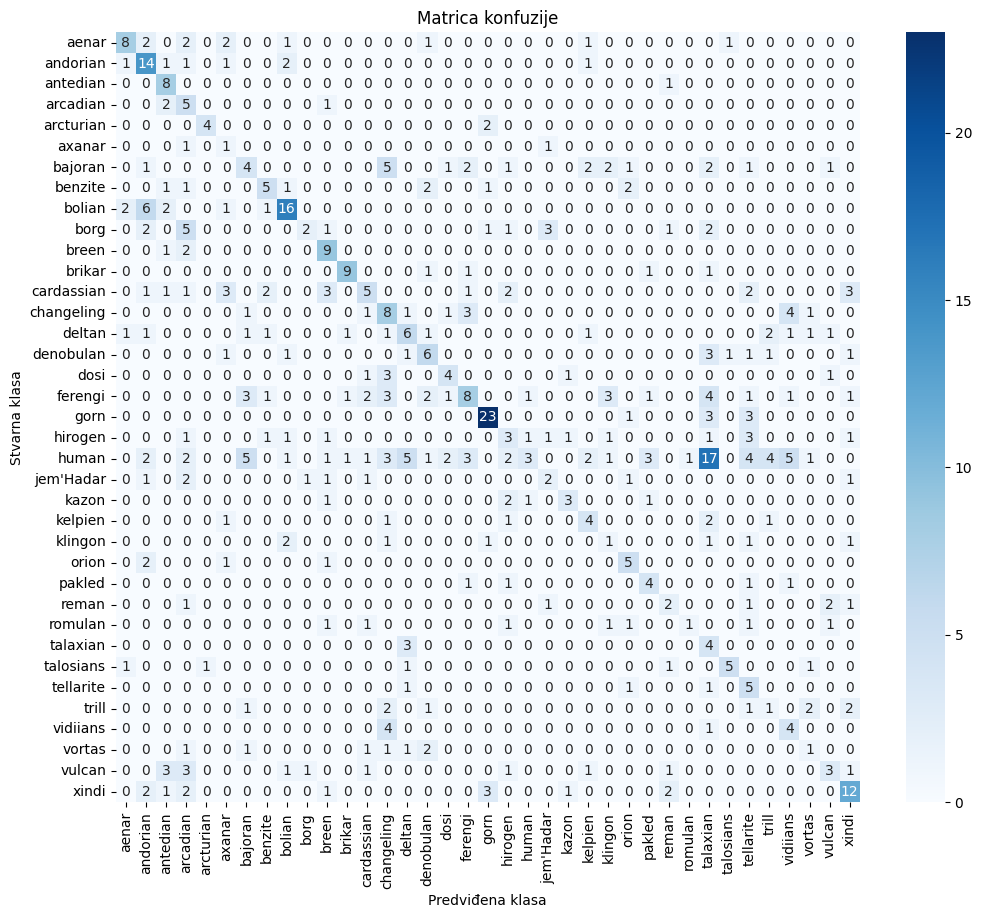

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definisanje svih klasa
sortirani_nazivi_klasa = sorted(os.listdir(test_dir))
class_names = sortirani_nazivi_klasa  # Sortiranje klasa

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=class_names, columns=class_names)

# Prikazivanje matrice konfuzije
plt.figure(figsize=(12, 10))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Sada cu isti model trenirati na vestacki generisanim podacima kako bih uporedila njegove performanse.

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator



trening_dir = './ip2-projekat/skup_podataka_vestacki/trening'
test_dir = './ip2-projekat/skup_podataka_vestacki/test'

batch_size = 32
img_height, img_width = 224, 224

# Kreiranje ImageDataGenerator-a sa normalizacijom
datagen = ImageDataGenerator(rescale=1.0 / 255.0, validation_split=0.2)

# Generator za trening (80% podataka)
train_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Deo za trening
)

# Generator za validaciju (20% podataka)
validation_generator = datagen.flow_from_directory(
    trening_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # Nije potrebno mešanje
    subset='validation'  # Deo za validaciju
)

# Generator za test skup (bez podele)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Test ne mešamo da bismo dobili tačne metrike
)

Found 5000 images belonging to 37 classes.
Found 1231 images belonging to 37 classes.
Found 2843 images belonging to 37 classes.


In [15]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(37, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [16]:
epohe = 50
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs=epohe
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.1113 - loss: 3.4232 - val_accuracy: 0.1803 - val_loss: 3.0823
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.1814 - loss: 3.0520 - val_accuracy: 0.2031 - val_loss: 2.8834
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.2050 - loss: 2.8475 - val_accuracy: 0.2364 - val_loss: 2.6856
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.2338 - loss: 2.6552 - val_accuracy: 0.2770 - val_loss: 2.5292
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.2604 - loss: 2.5243 - val_accuracy: 0.2884 - val_loss: 2.4166
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.2675 - loss: 2.4578 - val_accuracy: 0.2973 - val_loss: 2.4464
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.2953 - loss: 2.3767 - val_accuracy: 0.3371 - val_loss: 2.2757
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.3128 - loss: 2.2914 - val_accura

Model je na trening skupu postigao tačnost do 85%, što ukazuje da je uspešno naučio obrasce iz podataka.
Međutim, tačnost na test skupu iznosi samo 60%, što ukazuje na značajan pad performansi pri generalizaciji na nepoznate podatke.


In [18]:
gubitak, preciznost = model.evaluate(test_generator)
print("Preciznost na test skupu:", preciznost)
print("Gubitak na test skupu:", gubitak)

89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.6738 - loss: 1.9454
Preciznost na test skupu: 0.6095673441886902
Gubitak na test skupu: 2.471303939819336


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Predikcije modela za test skup
predikcije = np.argmax(model.predict(test_generator), axis=-1)


# Pretvaranje stvarnih vrednosti u indekse (ako su one u one-hot kodiranju)
stvarno = test_generator.classes

# Izračunavanje matrice konfuzije
matrica_konfuzije = confusion_matrix(stvarno, predikcije)

# Provera da li je matrica konfuzije dobro izračunata
print(f"Dimenzije matrice konfuzije: {matrica_konfuzije.shape}")


89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step
Dimenzije matrice konfuzije: (37, 37)


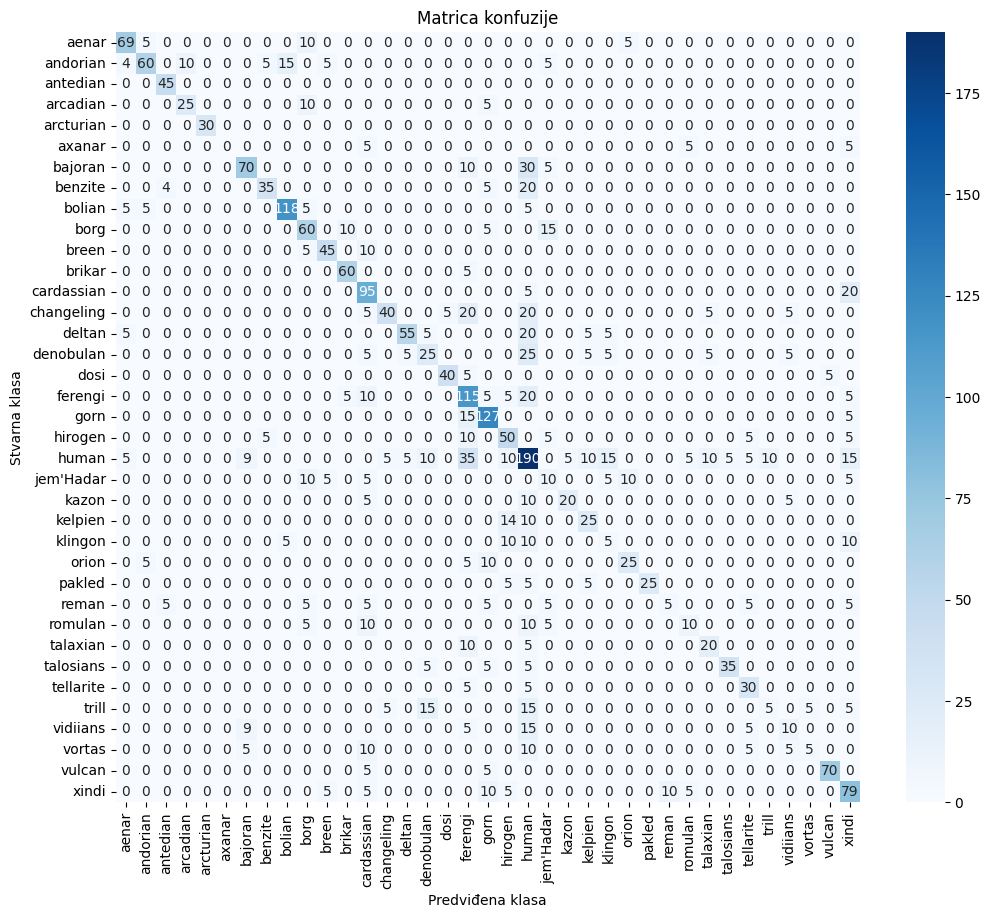

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Definisanje svih klasa
sortirani_nazivi_klasa = sorted(os.listdir(test_dir))
class_names = sortirani_nazivi_klasa  # Sortiranje klasa

# Kreiranje DataFrame-a za matricu konfuzije
matrica_df = pd.DataFrame(matrica_konfuzije, index=class_names, columns=class_names)

# Prikazivanje matrice konfuzije
plt.figure(figsize=(12, 10))
sns.heatmap(matrica_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predviđena klasa')
plt.ylabel('Stvarna klasa')
plt.title('Matrica konfuzije')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

**Dobre performanse za određene klase**

Model je tačno klasifikovao određene klase sa velikim brojem uzoraka, kao što su:
Cardassian (95 tačnih klasifikacija)
Bolian (115 tačnih klasifikacija)
Human (190 tačnih klasifikacija)
Ove klase su dobro naučene i model ih prepoznaje sa visokom tačnošću.

**Loša klasifikacija za određene klase**

Klasa Aenar – Model je 69 puta tačno klasifikovao Aenar primerke, ali je ponekad mešao sa Andorian i nekoliko drugih klasa.
Klasa Andorian – 60 tačnih predikcija, ali dosta mešanja sa Antedian, Bajoran i Ferengi.
Klasa Klingon – Model je imao problema sa razlikovanjem, često mešajući sa Orion i Tellarite.
Klasa Xindi – 79 tačnih predikcija, ali i nekoliko grešaka.

**Klase sa visokim brojem grešaka**

Changeling – 40 tačnih, ali dosta predikcija u pogrešne klase (Breen, Orion, itd.).
Deltan – 55 tačnih, ali često pomešan sa drugim klasama.
Vulcan – 70 tačnih, ali zbunjivanje sa drugim humanoidnim vrstama.